<a href="https://colab.research.google.com/github/RashaAlshawi/Dual-Attention-U-Net-with-Feature-Infusion-Pushing-the-Boundaries-of-Multiclass-Defect-Segmentation/blob/main/DAU_FI_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The DAU-FI Net for semantic segmentation, excelling in challenging scenarios like multiclass imbalanced datasets with limited samples. Through innovative features like multiscale spatial-channel attention and precise feature injection, it enhances object localization accuracy. The core employs a  multiscale depth-separable convolution block, complemented by a spatial-channel squeeze and excitation (scSE) unit. Additive attention gates connect encoder-decoder pathways, further refining segmentation results.
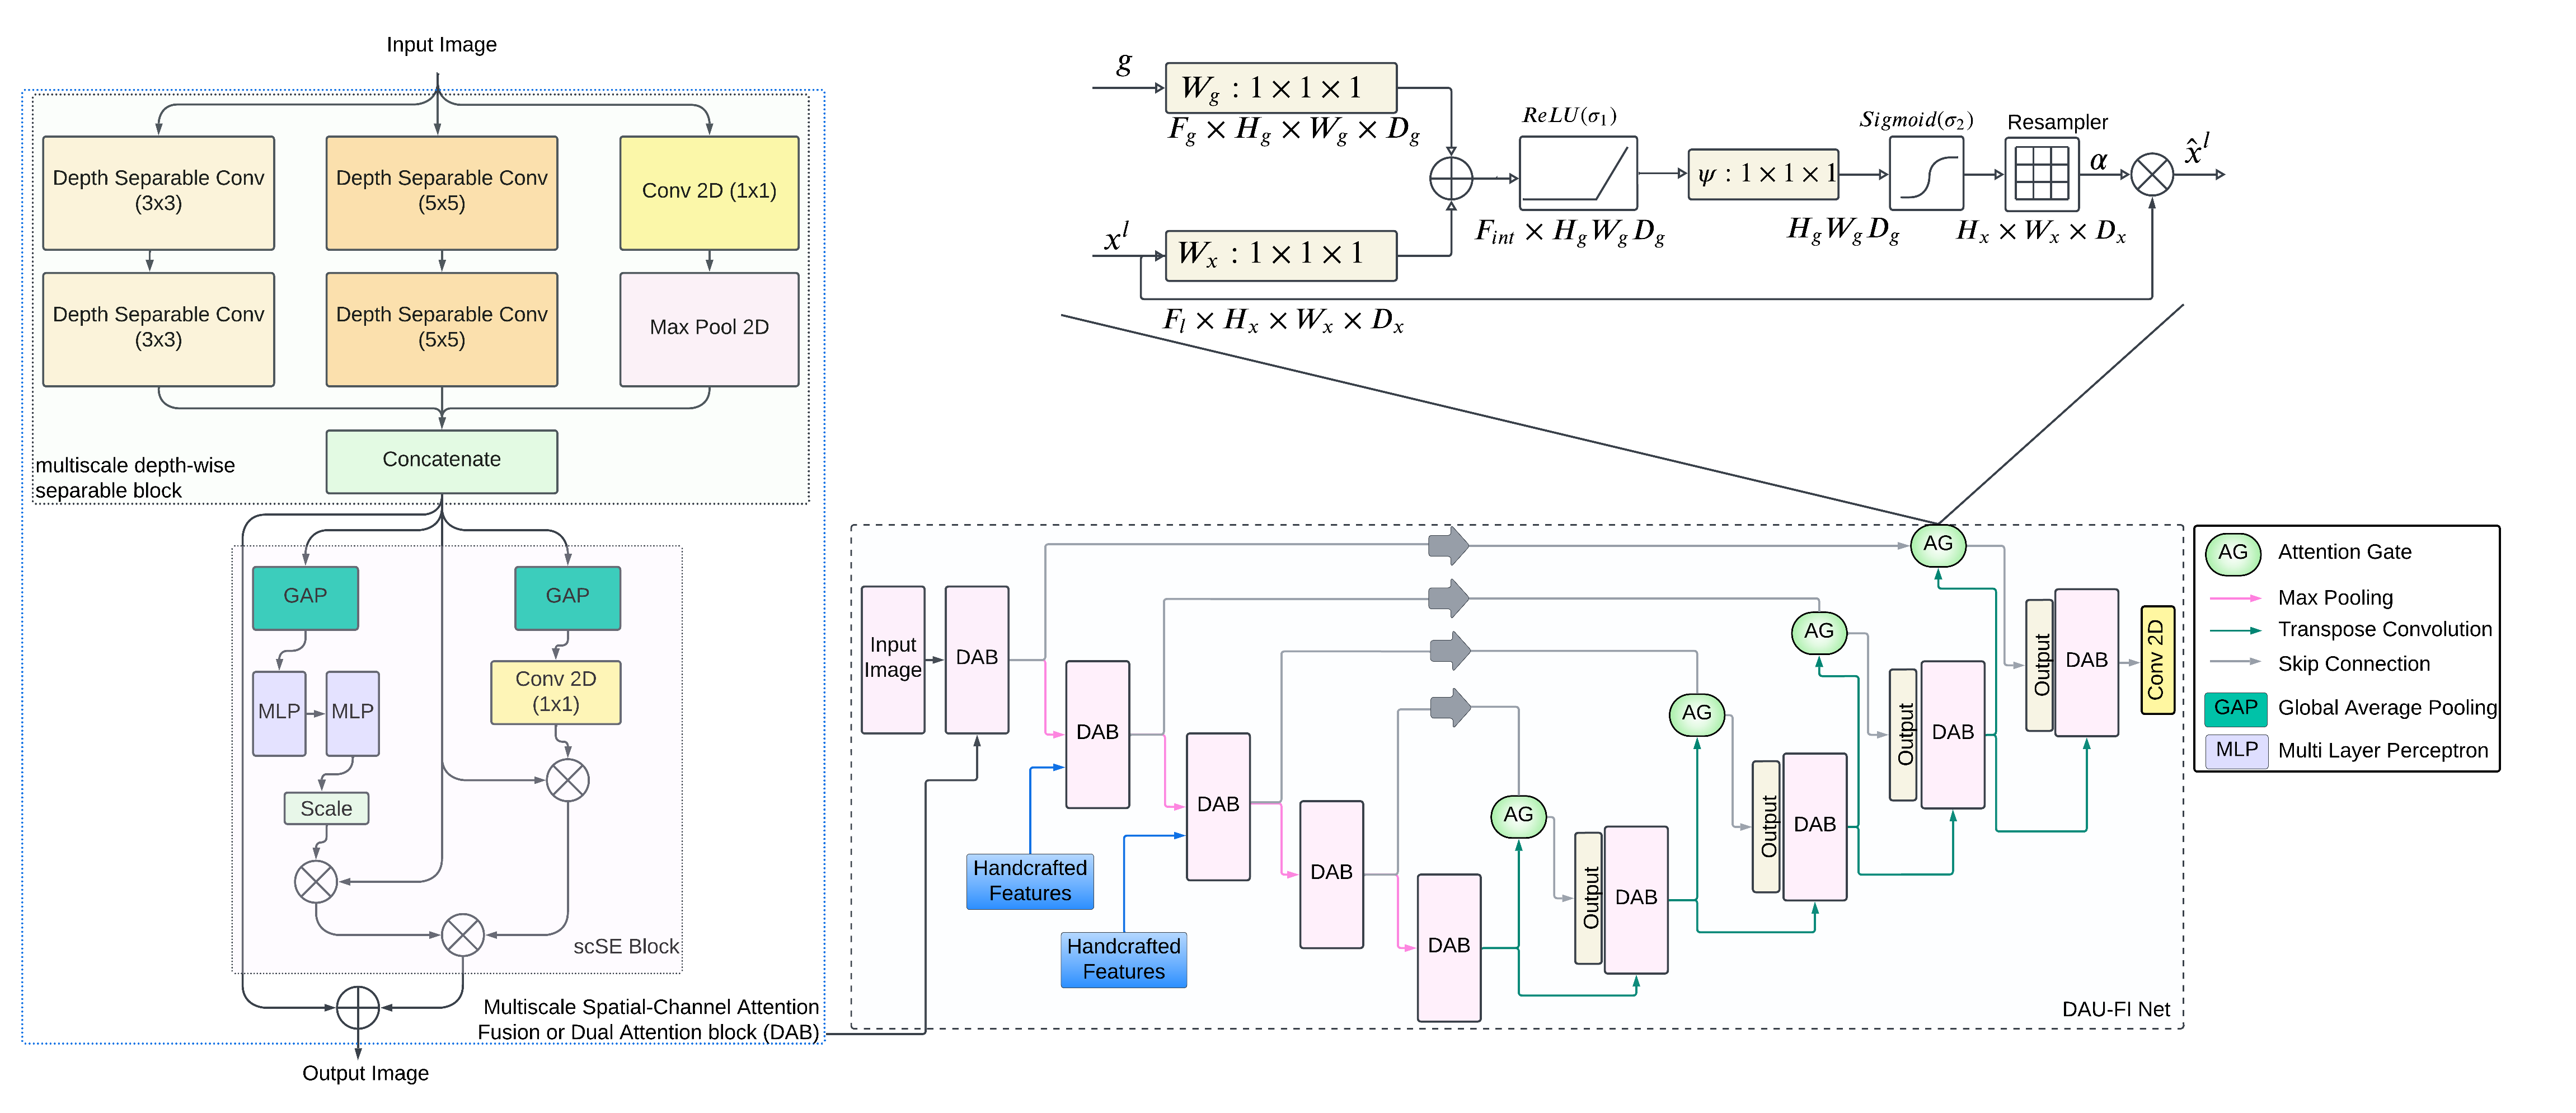



In [4]:
#@title Import Libraries

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, SeparableConv2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, initializers
from tensorflow.keras import layers
from tensorflow.keras.layers import Add, Multiply
import math
import numpy as np
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras import backend as K
import datetime
from keras.utils import to_categorical
from keras import backend as K
%env SM_FRAMEWORK=tf.keras
!pip install segmentation_models
import segmentation_models as sm
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
#import tensorflow_addons as tfa

#Blocks

In [ ]:
def convblock(inputs, n_filters, size=3, activation='relu', batch_normalization=True):
    conv = Conv2D(n_filters, (size, size), padding='same')(inputs)
    if batch_normalization:
        conv = BatchNormalization()(conv)
    conv = Activation(activation)(conv)
    conv = Conv2D(n_filters, (size, size), padding='same')(conv)
    if batch_normalization:
        conv = BatchNormalization()(conv)
    conv = Activation(activation)(conv)
    return conv

In [ ]:
#Depth Wise Separable Block
def inception_sepconvblock(inputs, f1, f2, f3):
    conva = SeparableConv2D(f1, (3, 3), activation='relu', padding='same')(inputs)
    conva = SeparableConv2D(f1, (3, 3), activation='relu', padding='same')(conva)

    convb = SeparableConv2D(f2, (5, 5), activation='relu', padding='same')(inputs)
    convb = SeparableConv2D(f2, (5, 5), activation='relu', padding='same')(convb)

    convc = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    convc = Conv2D(f3, (1, 1), padding='same')(convc)

    concatenated = concatenate([conva, convb, convc])
    print(concatenated.shape)

    return concatenated

In [ ]:
#Depth Wise Separable Block with Residual Connection
def inception_sepconvblock(inputs, f1, f2, f3):
    conva = SeparableConv2D(f1, (3, 3), activation='relu', padding='same')(inputs)
    conva = SeparableConv2D(f1, (3, 3), activation='relu', padding='same')(conva)

    convb = SeparableConv2D(f2, (5, 5), activation='relu', padding='same')(inputs)
    convb = SeparableConv2D(f2, (5, 5), activation='relu', padding='same')(convb) #, dilation_rate=3

    convc = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    convc = SeparableConv2D(f3, (1, 1), padding='same')(convc)
    concatenated = concatenate([conva, convb, convc])
    print(concatenated.shape[3])
    residual = SeparableConv2D(concatenated.shape[3], (1, 1), padding='same')(inputs)
    print(residual.shape)
    out = Add()([concatenated, residual])
    return out


In [ ]:
# Original SE block

def squeeze_excitation_block(inputs, reduction_ratio=16):
    channels = inputs.shape[-1]

    # Squeeze phase
    x = layers.GlobalAveragePooling2D()(inputs)

    # Excitation phase
    x = layers.Dense(channels // reduction_ratio, activation='relu')(x)
    x = layers.Dense(channels, activation='sigmoid')(x)

    # Reshape and scale
    x = tf.reshape(x, [-1, 1, 1, channels])
    scaled_inputs = inputs * x

    return scaled_inputs


In [ ]:
#Spatial-Channel Squeeze and Excitation
def channel_squeeze_excitation(input_tensor, reduction_ratio=2, activation='relu'):
    num_channels = input_tensor.shape[-1]
    num_channels_reduced = num_channels // reduction_ratio
    # Squeeze
    #    squeeze_tensor = tf.reduce_mean(input_tensor, axis=[1, 2])  # shape: (batch_size, num_channels)

    global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
    squeeze_tensor = global_avg_pool(input_tensor)

    # Excitation
    fc1 = tf.keras.layers.Dense(num_channels_reduced, activation=activation)
    fc2 = tf.keras.layers.Dense(num_channels, activation='sigmoid')

    fc_out_1 = fc1(squeeze_tensor)
    fc_out_2 = fc2(fc_out_1)

    output_tensor = input_tensor * tf.expand_dims(tf.expand_dims(fc_out_2, axis=1), axis=1)
    return output_tensor


def spatial_squeeze_excitation(input_tensor):
    num_channels = input_tensor.shape[-1]
    # Squeeze
    global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
    squeeze_tensor = global_avg_pool(input_tensor)
    squeeze_tensor = tf.expand_dims(tf.expand_dims(squeeze_tensor, axis=1), axis=1)

    # Excitation
    conv = tf.keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid')

    squeeze_tensor = conv(squeeze_tensor)
    print('squeeze_tensor',squeeze_tensor.shape)

    output_tensor = input_tensor * squeeze_tensor
    return output_tensor


def channel_spatial_squeeze_excitation(input_tensor, reduction_ratio=2):
    cse_output = channel_squeeze_excitation(input_tensor, reduction_ratio)
    sse_output = spatial_squeeze_excitation(input_tensor)
    output_tensor = cse_output + sse_output
    #print(output_tensor.shape)
    return output_tensor


In [ ]:
### An Improved Spatial-Channel Squeeze and Excitation (scSE) with Learnable Reduction Ratio as a Trainable Variable
def channel_squeeze_excitation(input_tensor, reduction_ratio=2, activation='relu'):
    num_channels = input_tensor.shape[-1]
    num_channels_reduced = num_channels // reduction_ratio

    global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

    # Define a learnable reduction ratio as a trainable variable
    reduction_ratio = tf.Variable(initial_value=reduction_ratio, trainable=True, dtype=tf.float32)
    num_channels_reduced = tf.cast(tf.math.round(num_channels / reduction_ratio), dtype=tf.int32)

    fc1 = tf.keras.layers.Dense(num_channels_reduced, activation=activation)(global_avg_pool)
    fc2 = tf.keras.layers.Dense(num_channels, activation='sigmoid')(fc1)

    output_tensor = input_tensor * tf.expand_dims(tf.expand_dims(fc2, axis=1), axis=1)
    return output_tensor

def spatial_squeeze_excitation(input_tensor):
    num_channels = input_tensor.shape[-1]
    # Squeeze
    global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
    squeeze_tensor = global_avg_pool(input_tensor)
    squeeze_tensor = tf.expand_dims(tf.expand_dims(squeeze_tensor, axis=1), axis=1)

    # Excitation
    conv = tf.keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid')

    squeeze_tensor = conv(squeeze_tensor)
    print('squeeze_tensor',squeeze_tensor.shape)

    output_tensor = input_tensor * squeeze_tensor
    return output_tensor


def channel_spatial_squeeze_excitation(input_tensor, reduction_ratio=2):
    cse_output = channel_squeeze_excitation(input_tensor, reduction_ratio)
    sse_output = spatial_squeeze_excitation(input_tensor)
    output_tensor = cse_output + sse_output
    #print(output_tensor.shape)
    return output_tensor


In [ ]:
def attention_gate(inputs, gate, inter_channels):
    g1 = SeparableConv2D(inter_channels, kernel_size=1, strides=1, padding='same')(gate)
    x1 = SeparableConv2D(inter_channels, kernel_size=1, strides=1, padding='same')(inputs)
    psi = layers.LeakyReLU()(g1 + x1)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(psi)
    psi = layers.Activation('sigmoid')(psi)
    out = inputs * psi
    return out

In [ ]:
# The Proposed Block
def inception_se_block(inputs, f1, f2, f3, reduction_ratio=2):
    inception_output = inception_sepconvblock(inputs, f1, f2, f3)
    se_output = channel_spatial_squeeze_excitation(inception_output, reduction_ratio)
    output = tf.keras.layers.Add()([inception_output, se_output])
    return output

output_tensor (None, 32, 32, 3)
(None, 32, 32, 3)
35
(None, 32, 32, 35)
output_tensor (None, 32, 32, 35)
(None, 32, 32, 35)

In [ ]:
input_shape=(32,32,3)
input_tensor= tf.keras.layers.Input(shape=input_shape)
csse_output = channel_spatial_squeeze_excitation(input_tensor, reduction_ratio=4)
csse_output=inception_se_block(input_tensor, 10, 20, 5, reduction_ratio=2)
#csse_output.shape


squeeze_tensor (None, 1, 1, 1)
(None, 32, 32, 35)
squeeze_tensor (None, 1, 1, 1)


# # Models

In [ ]:
input_shape=(128,128,3)

In [ ]:
#@title channel_spatial_squeeze_excitation on the Skip connections

""""With increased complexity """

def DepthWise_U_Net(dropout_rate=0.2,numClasses=0,activation='relu', activation2='relu'):
    "Depth Wise Separable scSE U-Net"
    inputs = tf.keras.layers.Input(shape=input_shape)
#inception_sepconvblock
    # Encoder
    #conv1 = convblock(inputs, 64, 3)
    conv1 = inception_sepconvblock(inputs,f1=34, f2=22, f3=8)
    max1 = tf.keras.layers.MaxPool2D((2, 2))(conv1)
    conv2 = inception_sepconvblock(max1, f1=84, f2=28, f3=16)
    max2 = tf.keras.layers.MaxPool2D((2, 2))(conv2)
    conv3 = inception_sepconvblock(max2, f1=128, f2=100, f3=28)
    max3 = tf.keras.layers.MaxPool2D((2, 2))(conv3)
    conv4 = inception_sepconvblock(max3, f1=256, f2=210, f3=46)
    max4=MaxPool2D((2,2))(conv4) #1
    # base
    conv5=inception_sepconvblock(max4,f1=512,f2=420,f3=92) #1024


    u6=Conv2DTranspose(512,(2,2),strides=(2,2),padding='same',activation=activation2)(conv5)
    se6 = channel_spatial_squeeze_excitation(conv4)
    conct1=concatenate([u6,se6])
    conv_4=inception_sepconvblock(conct1,f1=256,f2=210,f3=46)

    # Decoder with SE blocks on skip connections
    u7 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv4)
    se7 = channel_spatial_squeeze_excitation(conv3)
    conct2 = tf.keras.layers.concatenate([u7,se7])
    conv_3 = inception_sepconvblock(conct2, f1=128, f2=100, f3=28)
    conv_3 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_3)  # Add dropout layer


    u8 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_3)
    se8 = channel_spatial_squeeze_excitation(conv2)
    conct3 = tf.keras.layers.concatenate([se8, u8])
    conv_2 = inception_sepconvblock(conct3, f1=84, f2=28, f3=16)

    u9 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_2)
    se9 = channel_spatial_squeeze_excitation(conv1)
    conct4 = tf.keras.layers.concatenate([se9,u9 ])

    conv_1 = inception_sepconvblock(conct4,f1=34, f2=22, f3=8)
    conv_1 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_1)  # Add dropout layer


    output = tf.keras.layers.Conv2D(filters=numClasses, kernel_size=(1, 1), activation='sigmoid')(conv_1)

    model = tf.keras.Model(inputs=[inputs], outputs=[output])
    return model


In [ ]:
#@title The Proposed Model
def DepthWise_U_Net(dropout_rate=0.2,numClasses=9,activation='relu', activation2='relu',activation3='softmax'):
    "Depth Wise Separable U-Net"
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder

    conv1 = inception_se_block(inputs,f1=34, f2=22, f3=8)
    max1 = tf.keras.layers.MaxPool2D((2, 2))(conv1)
    conv2 = inception_se_block(max1, f1=84, f2=28, f3=16)
    # adding features
    max2 = tf.keras.layers.MaxPool2D((2, 2))(conv2)
    conv3 = inception_se_block(max2, f1=128, f2=100, f3=28)


    max3 = tf.keras.layers.MaxPool2D((2, 2))(conv3)
    #base
    conv4 = inception_se_block(max3, f1=256, f2=210, f3=46)
    max4=MaxPool2D((2,2))(conv4) #1

    conv5=inception_se_block(max4,f1=512,f2=420,f3=92) #1024

    u6=Conv2DTranspose(512,(2,2),strides=(2,2),padding='same',activation=activation2)(conv5)
    gated_conv4 = attention_gate(conv4, u6, 128)
    conct10 = tf.keras.layers.concatenate([gated_conv4, u6])
    conv_4=inception_se_block(conct10,f1=256,f2=210,f3=46)

    # Decoder with SE blocks on skip connections
    u7 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv4)
    gated_conv3 = attention_gate(conv3, u7, 64)
    conct2 = tf.keras.layers.concatenate([gated_conv3, u7])
    conv_3 = inception_se_block(conct2, f1=128, f2=100, f3=28)
    conv_3 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_3)  # Add dropout layer


    u8 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_3)
    gated_conv2 = attention_gate(conv2, u8, 32)
    conct3 = tf.keras.layers.concatenate([gated_conv2, u8])
    conv_2 = inception_se_block(conct3, f1=84, f2=28, f3=16)
    u9 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_2)
    gated_conv1 = attention_gate(conv1, u9, 16)
    conct1 = tf.keras.layers.concatenate([gated_conv1, u9])
    conv_1 = inception_se_block(conct1,f1=34, f2=22, f3=8)
    conv_1 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_1)  # Add dropout layer

    output = tf.keras.layers.Conv2D(filters=numClasses, kernel_size=(1, 1), activation=activation3)(conv_1)

    model = tf.keras.Model(inputs=[inputs], outputs=[output])
    return model


In [ ]:
#@title The Proposed Model without Attention Gate
def DepthWise_U_Net(dropout_rate=0.2,numClasses=0,activation='relu', activation2='relu',activation3='softmax'):
    "Depth Wise Separable U-Net"
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder

    conv1 = inception_se_block(inputs,f1=34, f2=22, f3=8)
    max1 = tf.keras.layers.MaxPool2D((2, 2))(conv1)
    conv2 = inception_se_block(max1, f1=84, f2=28, f3=16)
    max2 = tf.keras.layers.MaxPool2D((2, 2))(conv2)
    conv3 = inception_se_block(max2, f1=128, f2=100, f3=28)
    max3 = tf.keras.layers.MaxPool2D((2, 2))(conv3)
    #base
    conv4 = inception_se_block(max3, f1=256, f2=210, f3=46)
    max4=MaxPool2D((2,2))(conv4) #1

    conv5=inception_se_block(max4,f1=512,f2=420,f3=92) #1024
    print('conv5',conv5.shape)

    u6=Conv2DTranspose(512,(2,2),strides=(2,2),padding='same',activation=activation2)(conv5)
    conct10 = tf.keras.layers.concatenate([conv4, u6])
    conv_4=inception_se_block(conct10,f1=256,f2=210,f3=46)

    # Decoder with SE blocks on skip connections
    u7 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv4)
    conct2 = tf.keras.layers.concatenate([conv3, u7])
    conv_3 = inception_se_block(conct2, f1=128, f2=100, f3=28)
    conv_3 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_3)  # Add dropout layer


    u8 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_3)
    conct3 = tf.keras.layers.concatenate([conv2, u8])
    conv_2 = inception_se_block(conct3, f1=84, f2=28, f3=16)

    u9 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_2)
    conct1 = tf.keras.layers.concatenate([conv1, u9])
    conv_1 = inception_se_block(conct1,f1=34, f2=22, f3=8)
    conv_1 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_1)  # Add dropout layer


    output = tf.keras.layers.Conv2D(filters=numClasses, kernel_size=(1, 1), activation=activation3)(conv_1)

    model = tf.keras.Model(inputs=[inputs], outputs=[output])
    return model


In [ ]:
#@title  The Proposed Model With Two Inputs (External Feature Injection)

from keras import backend as K
number_of_channels=3
input_shape=(128,128,3)
input_shape2=(64,64,number_of_channels)
def DepthWise_U_Net(dropout_rate=0.2,numClasses=7,activation='relu', activation2='relu',activation3='softmax'):
    "Depth Wise Separable U-Net"
    inputs = tf.keras.layers.Input(shape=input_shape)
    input2 = tf.keras.layers.Input(shape=input_shape2)
    # Encoder
    conv1 = inception_se_block(inputs,f1=34, f2=22, f3=8)
    max1 = tf.keras.layers.MaxPool2D((2, 2))(conv1)
    conv2 = inception_se_block(max1, f1=84, f2=28, f3=16)


    conv2_f=SeparableConv2D(number_of_channels, (1, 1), activation='linear')(conv2)
    conv2_f =layers.LeakyReLU()(conv2_f + input2)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(conv2_f)
    psi = layers.Activation('sigmoid')(psi)
    conv2 = conv2 * psi


    max2 = tf.keras.layers.MaxPool2D((2, 2))(conv2)

    conv3 = inception_se_block(max2, f1=128, f2=100, f3=28)
    max_features = tf.keras.layers.MaxPool2D((2, 2))(input2)
    conv3 = tf.concat([conv3, max_features], axis=-1)
    max3 = tf.keras.layers.MaxPool2D((2, 2))(conv3)

    #base
    conv4 = inception_se_block(max3, f1=256, f2=210, f3=46)
    max4=MaxPool2D((2,2))(conv4) #1

    conv5=inception_se_block(max4,f1=512,f2=420,f3=92) #1024
    #1. Upsample
    #2. attention takes layer+upsampled
    #concat=   attentiom +upsampled
    #block(concat)

    u6=Conv2DTranspose(512,(2,2),strides=(2,2),padding='same',activation=activation2)(conv5)
    gated_conv4 = attention_gate(conv4, u6, 128)
    conct10 = tf.keras.layers.concatenate([gated_conv4, u6])
    conv_4=inception_se_block(conct10,f1=256,f2=210,f3=46)

    # Decoder with SE blocks on skip connections
    u7 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv4)
    gated_conv3 = attention_gate(conv3, u7, 64)
    conct2 = tf.keras.layers.concatenate([gated_conv3, u7])
    conv_3 = inception_se_block(conct2, f1=128, f2=100, f3=28)
    conv_3 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_3)  # Add dropout layer


    u8 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_3)
    gated_conv2 = attention_gate(conv2, u8, 32)
    conct3 = tf.keras.layers.concatenate([gated_conv2, u8])
    conv_2 = inception_se_block(conct3, f1=84, f2=28, f3=16)
    u9 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_2)
    gated_conv1 = attention_gate(conv1, u9, 16)
    conct1 = tf.keras.layers.concatenate([gated_conv1, u9])
    conv_1 = inception_se_block(conct1,f1=34, f2=22, f3=8)
    conv_1 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_1)  # Add dropout layer

    output = tf.keras.layers.Conv2D(filters=numClasses, kernel_size=(1, 1), activation=activation3)(conv_1)

    model = tf.keras.Model(inputs=[inputs,input2], outputs=[output])
    return model


In [ ]:
#@title The Poposed Block on Only Decoder Part with Attention Gate

def DepthWise_U_Net(dropout_rate=0.2,numClasses=0,activation='relu', activation2='relu',activation3='softmax'):
    "Depth Wise Separable U-Net"
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder

    conv1 = inception_sepconvblock(inputs,f1=34, f2=22, f3=8)
    max1 = tf.keras.layers.MaxPool2D((2, 2))(conv1)
    conv2 = inception_sepconvblock(max1, f1=84, f2=28, f3=16)
    max2 = tf.keras.layers.MaxPool2D((2, 2))(conv2)
    conv3 = inception_sepconvblock(max2, f1=128, f2=100, f3=28)
    max3 = tf.keras.layers.MaxPool2D((2, 2))(conv3)
    #base
    conv4 = inception_sepconvblock(max3, f1=256, f2=210, f3=46)
    max4=MaxPool2D((2,2))(conv4) #1

    conv5=inception_sepconvblock(max4,f1=512,f2=420,f3=92) #1024
    print('conv5',conv5.shape)

    u6=Conv2DTranspose(512,(2,2),strides=(2,2),padding='same',activation=activation2)(conv5)
    gated_conv4 = attention_gate(conv4, u6, 128)
    conct10 = tf.keras.layers.concatenate([gated_conv4, u6])
    conv_4=inception_se_block(conct10,f1=256,f2=210,f3=46)

    # Decoder with SE blocks on skip connections
    u7 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv4)
    gated_conv3 = attention_gate(conv3, u7, 64)
    conct2 = tf.keras.layers.concatenate([gated_conv3, u7])
    conv_3 = inception_se_block(conct2, f1=128, f2=100, f3=28)
    conv_3 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_3)  # Add dropout layer


    u8 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_3)
    gated_conv2 = attention_gate(conv2, u8, 32)
    conct3 = tf.keras.layers.concatenate([gated_conv2, u8])
    print('conct3',conct3.shape)
    conv_2 = inception_se_block(conct3, f1=84, f2=28, f3=16)
    print('conv_2',conv_2.shape)
    u9 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_2)
    gated_conv1 = attention_gate(conv1, u9, 16)
    conct1 = tf.keras.layers.concatenate([gated_conv1, u9])
    conv_1 = inception_se_block(conct1,f1=34, f2=22, f3=8)
    conv_1 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_1)  # Add dropout layer


    output = tf.keras.layers.Conv2D(filters=numClasses, kernel_size=(1, 1), activation=activation3)(conv_1)

    model = tf.keras.Model(inputs=[inputs], outputs=[output])
    return model


In [ ]:
#@title Depth-Wise Separable Model With Attention Gates "[1]"
def DepthWise_U_Net(dropout_rate=0.2,numClasses=0,activation='relu', activation2='relu',activation3='softmax'):
    "Depth Wise Separable U-Net"
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder

    conv1 = inception_sepconvblock(inputs,f1=34, f2=22, f3=8)
    max1 = tf.keras.layers.MaxPool2D((2, 2))(conv1)
    conv2 = inception_sepconvblock(max1, f1=84, f2=28, f3=16)
    max2 = tf.keras.layers.MaxPool2D((2, 2))(conv2)
    conv3 = inception_sepconvblock(max2, f1=128, f2=100, f3=28)
    max3 = tf.keras.layers.MaxPool2D((2, 2))(conv3)
    conv4 = inception_sepconvblock(max3, f1=256, f2=210, f3=46)
    max4=MaxPool2D((2,2))(conv4) #1

     #Base
    conv5=inception_sepconvblock(max4,f1=512,f2=420,f3=92) #1024


     # Decoder
    u6=Conv2DTranspose(512,(2,2),strides=(2,2),padding='same',activation=activation2)(conv5)
    gated_conv4 = attention_gate(conv4, u6, 128)
    conct10 = tf.keras.layers.concatenate([gated_conv4, u6])
    conv_4=inception_sepconvblock(conct10,f1=256,f2=210,f3=46)
    u7 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv4)
    gated_conv3 = attention_gate(conv3, u7, 64)
    conct2 = tf.keras.layers.concatenate([gated_conv3, u7])
    conv_3 = inception_sepconvblock(conct2, f1=128, f2=100, f3=28)
    conv_3 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_3)  # Add dropout layer


    u8 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_3)
    gated_conv2 = attention_gate(conv2, u8, 32)
    conct3 = tf.keras.layers.concatenate([gated_conv2, u8])
    conv_2 = inception_sepconvblock(conct3, f1=84, f2=28, f3=16)
    u9 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_2)
    gated_conv1 = attention_gate(conv1, u9, 16)
    conct1 = tf.keras.layers.concatenate([gated_conv1, u9])
    conv_1 = inception_sepconvblock(conct1,f1=34, f2=22, f3=8)
    conv_1 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_1)  # Add dropout layer


    output = tf.keras.layers.Conv2D(filters=numClasses, kernel_size=(1, 1), activation=activation3)(conv_1)

    model = tf.keras.Model(inputs=[inputs], outputs=[output])
    return model



In [ ]:
#@title Depth-Wise Separable Model With Attention Gates "[1]"


""""With increased complexity """
def DepthWise_U_Net(dropout_rate=0.2,numClasses=0,activation='relu', activation2='relu',activation3='softmax'):
    "Depth Wise Separable scSE U-Net"
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    #conv1 = convblock(inputs, 64, 3)
    conv1 = inception_sepconvblock(inputs,f1=34, f2=22, f3=8)
    max1 = tf.keras.layers.MaxPool2D((2, 2))(conv1)
    conv2 = inception_sepconvblock(max1, f1=84, f2=28, f3=16)
    max2 = tf.keras.layers.MaxPool2D((2, 2))(conv2)
    conv3 = inception_sepconvblock(max2, f1=128, f2=100, f3=28)
    max3 = tf.keras.layers.MaxPool2D((2, 2))(conv3)
    conv4 = inception_sepconvblock(max3, f1=256, f2=210, f3=46)
    max4=MaxPool2D((2,2))(conv4) #1
    # base
    conv5=inception_sepconvblock(max4,f1=512,f2=420,f3=92) #1024
    print('conv5',conv5.shape)



    u6=Conv2DTranspose(512,(2,2),strides=(2,2),padding='same',activation=activation2)(conv5)

    conct1=concatenate([u6,conv4])
    conv_4=inception_sepconvblock(conct1,f1=256,f2=210,f3=46)

    # Decoder with SE blocks on skip connections
    u7 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv4)
    conct2 = tf.keras.layers.concatenate([conv3,u7])
    conv_3 = inception_sepconvblock(conct2, f1=128, f2=100, f3=28)
    conv_3 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_3)  # Add dropout layer


    u8 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_3)

    conct3 = tf.keras.layers.concatenate([conv2, u8])
    conv_2 = inception_sepconvblock(conct3, f1=84, f2=28, f3=16)

    u9 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same', activation=activation2)(conv_2)

    conct4 = tf.keras.layers.concatenate([conv1,u9 ])

    conv_1 = inception_sepconvblock(conct4,f1=34, f2=22, f3=8)
    conv_1 = tf.keras.layers.Dropout(rate=dropout_rate)(conv_1)  # Add dropout layer


    output = tf.keras.layers.Conv2D(filters=numClasses, kernel_size=(1, 1), activation=activation3)(conv_1)

    model = tf.keras.Model(inputs=[inputs], outputs=[output])
    return model


In [ ]:
model=DepthWise_U_Net(numClasses=9, activation='relu', activation2='relu',activation3='softmax')#,activation3='sigmoid')

(None, 128, 128, 64)
squeeze_tensor (None, 1, 1, 1)
(None, 64, 64, 128)
squeeze_tensor (None, 1, 1, 1)
(None, 32, 32, 256)
squeeze_tensor (None, 1, 1, 1)
(None, 16, 16, 512)
squeeze_tensor (None, 1, 1, 1)
(None, 8, 8, 1024)
squeeze_tensor (None, 1, 1, 1)
(None, 16, 16, 512)
squeeze_tensor (None, 1, 1, 1)
(None, 32, 32, 256)
squeeze_tensor (None, 1, 1, 1)
(None, 64, 64, 128)
squeeze_tensor (None, 1, 1, 1)
(None, 128, 128, 64)
squeeze_tensor (None, 1, 1, 1)


In [ ]:
model.output_shape

(None, 128, 128, 9)

In [ ]:
model.input_shape

(None, 32, 32, 3)

#Load and Compile

In [ ]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

Segmentation Models: using `tf.keras` framework.


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]) #tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(),


In [ ]:
model.summary()

In [ ]:
#tf.keras.utils.plot_model(model,to_file= "model.png")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
X_P=np.load('/content/drive/MyDrive/VideoFrames/PositiveImageNew.npy')
y_P=np.load('/content/drive/MyDrive/VideoFrames/PositivemaskNew.npy')

In [13]:
# Import The Extracted Features
output_array=np.load('/content/drive/MyDrive/VideoFrames/output_array.npy')
filterResposne=np.load('/content/drive/MyDrive/VideoFrames/input_tensor_New.npy')

In [ ]:
plt.imshow(output_array[0])

In [ ]:
#@title Resizing the second input
from skimage.transform import resize
# Example data
batch_size = filterResposne.shape[0]
height = 128
width = 128
num_channels = 3

# Define the desired height and width after resizing
desired_height = 64
desired_width = 64

# Initialize the output array to store the resized data
output_array = np.zeros((batch_size, desired_height, desired_width, num_channels), dtype=filterResposne.dtype)

# Resize each image in the input array to the desired size
for i in range(batch_size):
    for j in range(num_channels):
        output_array[i, :, :, j] = resize(filterResposne[i, :, :, j], (desired_height, desired_width), preserve_range=True)



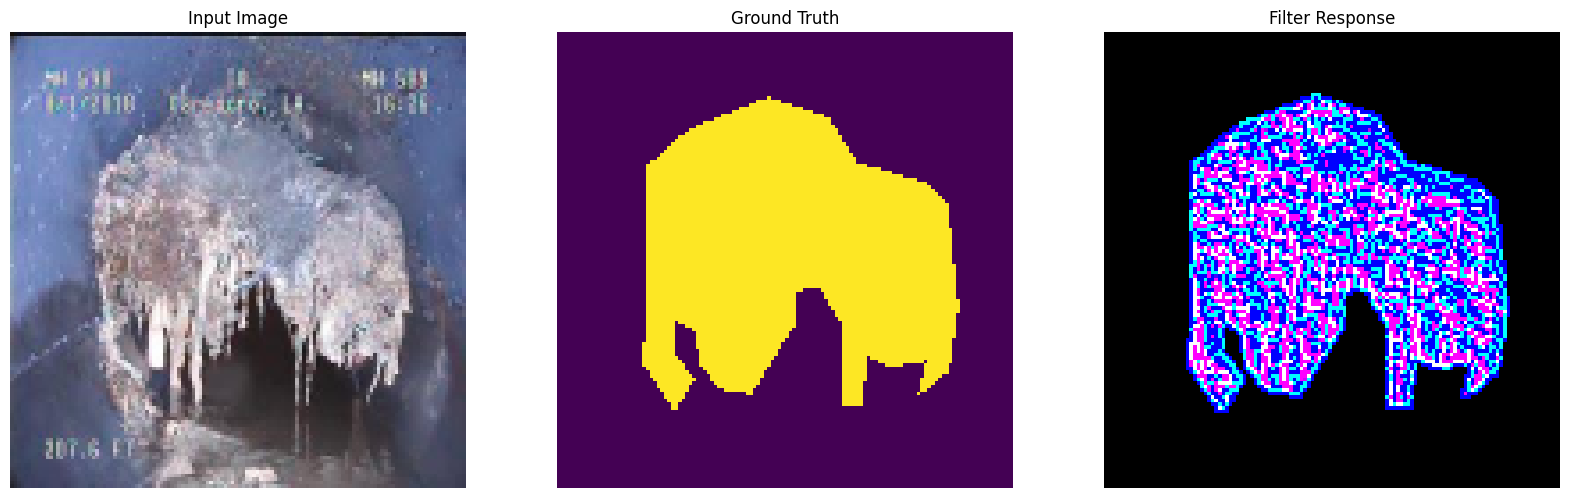

In [24]:
def plot_samples(X_P, y_P, filterResponse):
    fig, axes = plt.subplots(1, 3, figsize=(20, 20))
    # Plot the first sample
    axes[0].imshow(X_P)
    axes[0].set_title("Input Image")
    axes[0].set_axis_off()

    # Plot the second sample
    axes[1].imshow(y_P)
    axes[1].set_title("Ground Truth")
    axes[1].set_axis_off()
    # Plot the third sample
    axes[2].imshow(filterResponse)
    axes[2].set_title("Filter Response")
    axes[2].set_axis_off()

    plt.show()

i=10
plot_samples(X_P[i], y_P[i], filterResposne[i])


In [ ]:
filter_responseshow=filterResposne[:,:,:,1]

In [ ]:
#Shuffle the dataset without features
X_datas, y_datas = shuffle(X_P, y_P, random_state=10)

In [ ]:
#Shuffle the dataset with features
X_datas, y_datas, filter_responseShuffled = shuffle(X_P, y_P,output_array, random_state=10)

In [ ]:
#@title Dataset Normalization
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image
X_datas=normalize(X_datas)

In [ ]:
numClasses=9
train_masks_cat = to_categorical(y_datas, num_classes=numClasses)

In [ ]:
np.unique(y_datas)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8)

In [ ]:
y_train_cat = train_masks_cat.reshape((y_datas.shape[0], y_datas.shape[1], y_datas.shape[2], numClasses))

In [ ]:
samples_train = int(0.7 * len(X_datas))
samples_val = int(0.15 * len(X_datas))

X_train = X_datas[:samples_train]
X_input2 = filter_responseShuffled[:samples_train]
y_train = y_train_cat[:samples_train]

X_val = X_datas[samples_train:samples_train + samples_val]
X_val_input2=filter_responseShuffled[samples_train:samples_train + samples_val]
y_val = y_train_cat[samples_train:samples_train + samples_val]

X_test = X_datas[samples_train + samples_val:]
X_test_inut2=filter_responseShuffled[samples_train + samples_val:]
y_test = y_train_cat[samples_train + samples_val:]

In [ ]:
y_train.shape,X_train.shape,X_val.shape,y_val.shape,X_input2.shape

((3021, 128, 128, 9),
 (3021, 128, 128, 3),
 (647, 128, 128, 3),
 (647, 128, 128, 9),
 (3021, 64, 64, 3))

In [ ]:
samples_train = int(0.7 * len(X_datas))
samples_val = int(0.15 * len(X_datas))

X_train = X_datas[:samples_train]
y_train = y_train_cat[:samples_train]

X_val = X_datas[samples_train:samples_train + samples_val]
y_val = y_train_cat[samples_train:samples_train + samples_val]

X_test = X_datas[samples_train + samples_val:]
y_test = y_train_cat[samples_train + samples_val:]

# compile

In [ ]:
pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
filepath='/content/drive/MyDrive/best'

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=60),
    tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1,save_format='h5')
]

In [ ]:
my_callbacks=[
              tf.keras.callbacks.EarlyStopping(patience=20),
              tf.keras.callbacks.ModelCheckpoint(
                   filepath,save_best_only=True,monitor='val_loss'),
                  tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)]

In [ ]:
%tensorboard --logdir log

In [ ]:
#@title Training the model without features

history=model.fit(x=[X_train],y=y_train,epochs=100,validation_data=([X_val], y_val),batch_size=2,callbacks=my_callbacks)

In [ ]:
total_params = sum(np.prod(p.numpy().shape) for p in model.trainable_variables)
print("Total Trainable Parameters:", total_params)

Total Trainable Parameters: 1456961


In [15]:
#@title Training the model with features
history=model.fit(x=[X_train,X_input2],y=y_train,epochs=100,validation_data=([X_val, X_val_input2], y_val),batch_size=5,callbacks=my_callbacks)

In [ ]:
loaded_model = tf.keras.load_model(filepath+".h5",compile=True)

In [ ]:
c=pd.DataFrame(history.history)
c.to_csv('/content/drive/MyDrive/Fall20/modeladaptedwithfeatures')

<Axes: >

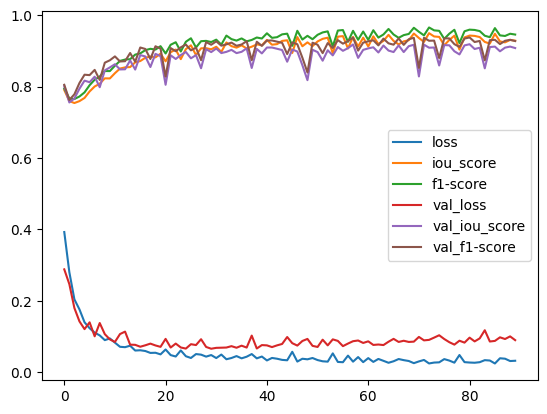

In [ ]:
c.plot() #

In [ ]:
model.evaluate([X_test,X_test_inut2],y_test)#[0.4265437722206116, 0.8815105557441711, 0.717641294002533]

24/24 [==============================] - 7s 223ms/step - loss: 0.0120 - iou_score: 0.8741 - f1-score: 0.8916


[0.011982031166553497, 0.8740982413291931, 0.891568660736084]

In [ ]:
#y_predict=model.predict([X_test,X_test_inut2])
y_predict=model.predict([X_test,X_test_inut2])

24/24 [==============================] - 5s 157ms/step


In [ ]:
y_test.shape
y_test2=y_datas[samples_train + samples_val:]

In [ ]:
y_predict_=np.argmax(y_predict, axis=-1)
y_test_=np.argmax(y_test, axis=3)

In [ ]:
model.save('/content/drive/MyDrive/model')

# Metrics- Model Evaluation



In [ ]:
# calculate_fwiou
def calculate_fwiou(predicted_mask, ground_truth_mask, class_frequencies):
    # Flatten the predicted and ground truth masks
    predicted_flat = K.flatten(predicted_mask)
    ground_truth_flat = K.flatten(ground_truth_mask)

    unique_classes = np.unique(ground_truth_flat)

    intersection_sum = 0
    union_sum = 0

    for class_val in unique_classes:
        class_mask = K.equal(ground_truth_flat, class_val)
        intersection = K.sum(K.cast(predicted_flat[class_mask] == class_val, K.floatx()))
        union = K.sum(K.cast((predicted_flat == class_val) | class_mask, K.floatx()))
        frequency = class_frequencies[class_val]

        intersection_sum += frequency * intersection
        union_sum += frequency * union

    fwiou = intersection_sum / union_sum

    return fwiou


In [ ]:
class_frequencies = {0: 0.0,
                     1: 1, # crack
                     2: 1, # Hole
                     3: 1, #root
                     4: 0.1622,#deformation
                     5:0.7100 , #fracture
                     6: 0.3518, #erosion
                     7: 0.6419, #joints
                     8: 0.5419 #loose gasket
                     }




In [ ]:
fwiou = calculate_fwiou(y_predict_, y_test_, class_frequencies)#0.7686044573783875
print(f"FWIoU: {fwiou}")

FWIoU: 0.9600428342819214


In [ ]:
# Define the mapping of object colors to RGB values
color_map = {
    0: [0, 0, 0],        # Background color
    1: [192, 209, 249],  # crack
    2: [191, 191, 191],  # hole
    3: [254, 255, 126],  # root
    4: [247, 205, 160],  # Deformation
    5:[246,202,255],  # Fracture
    6: [139, 2, 223],  # Erosion
    7: [188, 252, 176],  # joints
    8: [243,172,0] #loose_gasket

}

In [15]:
#Sampels: 10, 20, 26, 50, 57, 88, 83
i=88
print('features 3',i)
image = y_predict_[i]
# Map the object colors to RGB colors
rgb_imageP = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        rgb_imageP[i, j] = color_map[image[i, j]]
plt.axis('off')
plt.imshow(rgb_imageP);

Real: 83
[0 1]


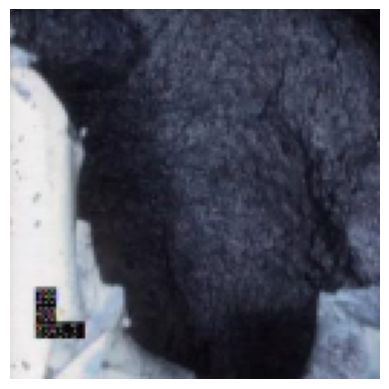

 Ground truth: 127


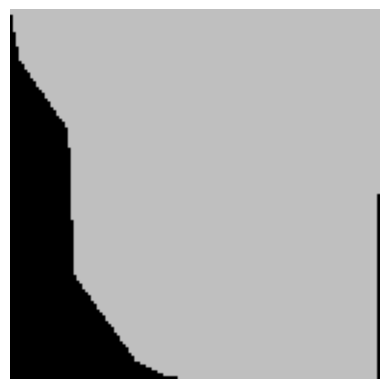

In [ ]:
i=83
image = y_test2[i]
print('Real:',i)
plt.axis('off')
plt.imshow(X_test[i])
print(np.unique( y_P[i]))
plt.show()
# Map the object colors to RGB colors
rgb_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        rgb_image[i, j] = color_map[image[i, j]]

print(' Ground truth:',i)
plt.axis('off')
plt.imshow(rgb_image)

In [ ]:
# Calculate the F1 score for each unique class separately
y_true_flat = y_test_.flatten()
y_pred_flat = y_predict_.flatten()

unique_classes = np.unique(np.concatenate([y_true_flat, y_pred_flat]))
f1_scores = {}
for class_value in unique_classes:
    binary_y_true = (y_true_flat == class_value)
    binary_y_pred = (y_pred_flat == class_value)
    f1_scores[class_value] = f1_score(binary_y_true, binary_y_pred)

# Print the F1 scores for each class
for class_value, f1_score_value in f1_scores.items():
    print(f"F1 Score for class {class_value}: {f1_score_value}")
# Calculate the average f1_scores for all classes
average_F1_all = np.mean(list(f1_scores.values()))
print(f"Average f1_scores (including class 0): {average_F1_all}")
# Calculate the average f1_scores excluding class 0
F1_scores_without_class_0 = {k: v for k, v in f1_scores.items() if k != 0}
average_F1_without_class_0 = np.mean(list(F1_scores_without_class_0.values()))
print(f"Average F1 (excluding class 0): {average_F1_without_class_0}")


F1 Score for class 0: 0.9991182960806185
F1 Score for class 1: 0.9781895076024569
F1 Score for class 2: 0.9950328058061477
F1 Score for class 3: 0.9852547392664045
F1 Score for class 4: 0.9816097332709406
F1 Score for class 5: 0.9562284655500848
F1 Score for class 6: 0.987243987146613
F1 Score for class 7: 0.9790936326618452
F1 Score for class 8: 0.9365573514151279
Average IoU (including class 0): 0.9775920576444711
Average IoU (excluding class 0): 0.9749012778399526


In [ ]:
# Calculate the IoU for each unique class separately
y_true_flat = y_test_.flatten()
y_pred_flat = y_predict_.flatten()

unique_classes = np.unique(np.concatenate([y_true_flat, y_pred_flat]))
iou_scores = {}
for class_value in unique_classes:
    intersection = np.sum((y_true_flat == class_value) & (y_pred_flat == class_value))
    union = np.sum((y_true_flat == class_value) | (y_pred_flat == class_value))

    iou_scores[class_value] = intersection / union

# Print the IoU scores for each class
for class_value, iou_score in iou_scores.items():
    print(f"IoU for class {class_value}: {iou_score}")

# Calculate the average IoU for all classes
average_iou_all = np.mean(list(iou_scores.values()))
print(f"Average IoU (including class 0): {average_iou_all}")

# Calculate the average IoU excluding class 0
iou_scores_without_class_0 = {k: v for k, v in iou_scores.items() if k != 0}
average_iou_without_class_0 = np.mean(list(iou_scores_without_class_0.values()))
print(f"Average IoU (excluding class 0): {average_iou_without_class_0}")


IoU for class 0: 0.998238145595171
IoU for class 1: 0.9573101028814696
IoU for class 2: 0.9901147137487671
IoU for class 3: 0.9709380052232309
IoU for class 4: 0.9638836557459909
IoU for class 5: 0.9161281314823679
IoU for class 6: 0.974809307095699
IoU for class 7: 0.9590435166103143
IoU for class 8: 0.8806844004812191
Average IoU (including class 0): 0.9567944420960255
Average IoU (excluding class 0): 0.9516139791586323


In [ ]:
label_mapping = {
    'background': 0,
    'crack': 1,
    'spiral_crack': 1,
    'hole': 2,
    'root': 3,
    'roots': 3,
    'Pipe_Deformed': 4,
    'deformation': 4,
     'fracture': 5,
    'erosion': 6,
     'encrustation': 6,
    'joint': 7,'joints':7,
    'joint_offset':7,'offset':7,
     'loose_gasket':8
}


In [ ]:

def calculate_pixel_acc(y_true, y_pred):
    assert y_true.shape == y_pred.shape, "Input arrays must have the same shape."

    total_pixels = np.prod(y_true.shape)
    correct_pixels = np.sum(y_true == y_pred)

    pixel_acc = correct_pixels / total_pixels

    return pixel_acc


In [ ]:
pixel_acc = calculate_pixel_acc(y_test_, y_predict_)
print("Pixel Accuracy:", pixel_acc)

Pixel Accuracy: 0.9784777629424922


In [ ]:
def calculate_balanced_accuracy(y_true, y_pred):
    unique_classes = np.unique(y_true)
    num_classes = 9

    class_accuracies = []

    for cls in unique_classes:
        true_mask = (y_true == cls)
        pred_mask = (y_pred == cls)

        class_accuracy = np.sum(true_mask & pred_mask) / np.sum(true_mask)
        class_accuracies.append(class_accuracy)

    balanced_acc = np.mean(class_accuracies)
    return balanced_acc
calculate_balanced_accuracy(y_test_,y_predict_)

0.9747817535946458

In [ ]:

# y_true and y_pred are NumPy arrays with shape (num_samples, height, width)
num_samples, height, width = y_test_.shape
num_classes = 9

# Reshape the arrays to 1D (num_samples * height * width,)
y_true_flat = y_test_.ravel()
y_pred_flat = y_predict_.ravel()

# Calculate the MCC for each class
mcc_scores = []
for class_idx in range(num_classes):
    class_true = (y_true_flat == class_idx)
    class_pred = (y_pred_flat == class_idx)
    mcc = matthews_corrcoef(class_true, class_pred)
    mcc_scores.append(mcc)

# Calculate the average MCC across all classes
mean_mcc = np.mean(mcc_scores)
mean_mcc

0.9763770356345568

In [ ]:
#2.calculate Matthews correlation coefficient
matthews_corrcoef(y_test_, y_predict_)

In [ ]:
calculate_balanced_accuracy(y_test_,y_predict_)

0.9661011645813122

In [ ]:
# Calculate pixel accuracy

num_samples, height, width = y_test_.shape
# Flatten the arrays to 1D (num_samples * height * width,)
y_true_flat = y_test_.reshape(-1)
y_pred_flat = y_predict_.reshape(-1)
pixel_accuracy = np.mean(y_true_flat == y_pred_flat)

# Convert pixel accuracy to percentage
pixel_accuracy_percent = pixel_accuracy * 100

print("Pixel Accuracy: {:.2f}%".format(pixel_accuracy_percent))


Pixel Accuracy: 97.26%
